# Project 6

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
data = pd.read_csv('RRCA_baseflow.csv')
data.head()

,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed
0,710732,144,1086190,14476800,0.59,18.99,0.0,0.145161
1,710763,144,1086190,14476800,0.97,29.63,0.0,0.445161
2,710791,144,1086190,14476800,1.34,29.63,0.0,1.332203
3,710822,144,1086190,14476800,1.79,29.63,0.0,2.932203
4,710852,144,1086190,14476800,8.23,29.63,0.0,3.728689


In [3]:
def getMonth(days):
    while days > 1461:
        days = days - 1461
    if days > 366:
        days = days - 366
    for _ in range(3):
        if days > 365:
            days = days - 365
    if 0 <= days <= 30:
        return 'Jan'
    elif 31 <= days <= 58:
        return 'Feb'
    elif 59 <= days <= 89:
        return 'Mar'
    elif 90 <= days <= 119:
        return 'Apr'
    elif 120 <= days <= 150:
        return 'May'
    elif 151 <= days <= 180:
        return 'Jun'
    elif 181 <= days <= 211:
        return 'Jul'
    elif 212 <= days <= 242:
        return 'Aug'
    elif 243 <= days <= 272:
        return 'Sep'
    elif 273 <= days <= 303:
        return 'Oct'
    elif 304 <= days <= 333:
        return 'Nov'
    elif 334 <= days <= 365:
        return 'Dec'
    else:
        return None

def getYear(days):
    year = 1900
    while days > 1461:
        days = days - 1461
        year += 4
    if days > 366:
        days = days - 366
        year += 1
    for _ in range(3):
        if days > 365:
            days = days - 365
            year += 1
    return year


In [4]:
data['Date'] = data.Date.apply(lambda x: x-693963)
data['Month'] = data.Date.apply(lambda x: getMonth(x))
data['Year'] = data.Date.apply(lambda x: getYear(x))

<Axes: xlabel='Month', ylabel='Observed'>

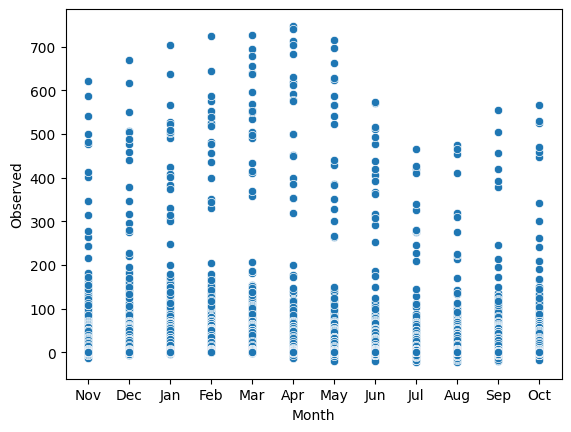

In [5]:
sns.scatterplot(data=data, x=data.Month, y=data.Observed)

In [6]:
month_dummies = pd.get_dummies(data.Month, prefix='Month').iloc[:, 1:]
data = pd.concat([data, month_dummies], axis=1)

segment_dummies = pd.get_dummies(data.Segment_id, prefix='Seg').iloc[:,1:]
data = pd.concat([data, segment_dummies], axis=1)
data.head()


,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed,Month,Year,...,Seg_176,Seg_178,Seg_186,Seg_188,Seg_189,Seg_194,Seg_196,Seg_205,Seg_239,Seg_256
0,16769,144,1086190,14476800,0.59,18.99,0.0,0.145161,Nov,1945,...,0,0,0,0,0,0,0,0,0,0
1,16800,144,1086190,14476800,0.97,29.63,0.0,0.445161,Dec,1945,...,0,0,0,0,0,0,0,0,0,0
2,16828,144,1086190,14476800,1.34,29.63,0.0,1.332203,Jan,1946,...,0,0,0,0,0,0,0,0,0,0
3,16859,144,1086190,14476800,1.79,29.63,0.0,2.932203,Feb,1946,...,0,0,0,0,0,0,0,0,0,0
4,16889,144,1086190,14476800,8.23,29.63,0.0,3.728689,Mar,1946,...,0,0,0,0,0,0,0,0,0,0


<Axes: xlabel='y', ylabel='Observed'>

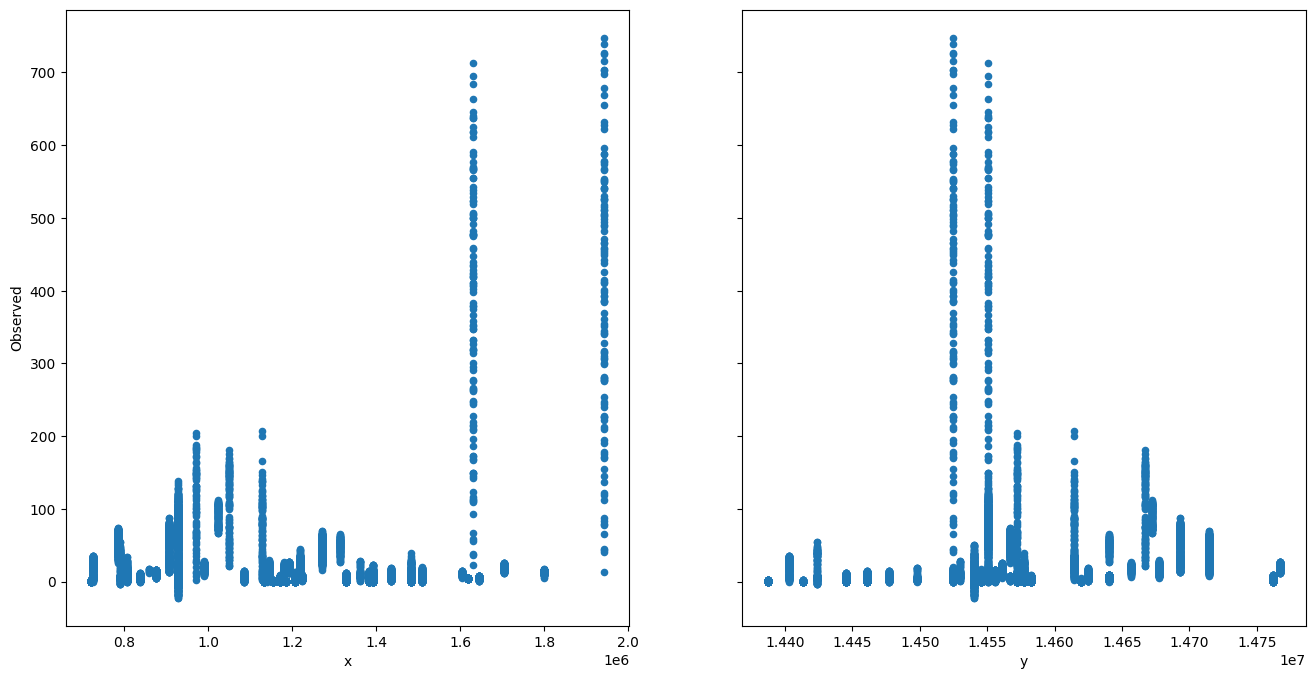

In [7]:
test = data[data.Month == 'Jan']
fig, axs = plt.subplots(1, 2, sharey=True)
data.plot(kind='scatter', x='x', y='Observed', ax=axs[0], figsize=(16, 8))
data.plot(kind='scatter', x='y', y='Observed', ax=axs[1])

In [8]:
data['avgOfFeatures'] = (data['Evapotranspiration'] + data['Precipitation'] + data['Irrigation_pumping'])/15591

In [9]:
columns = list(data.columns)
segList = []
for col in columns:
    if 'Seg_' in col:
        segList.append(col)

print(len(segList))

41


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


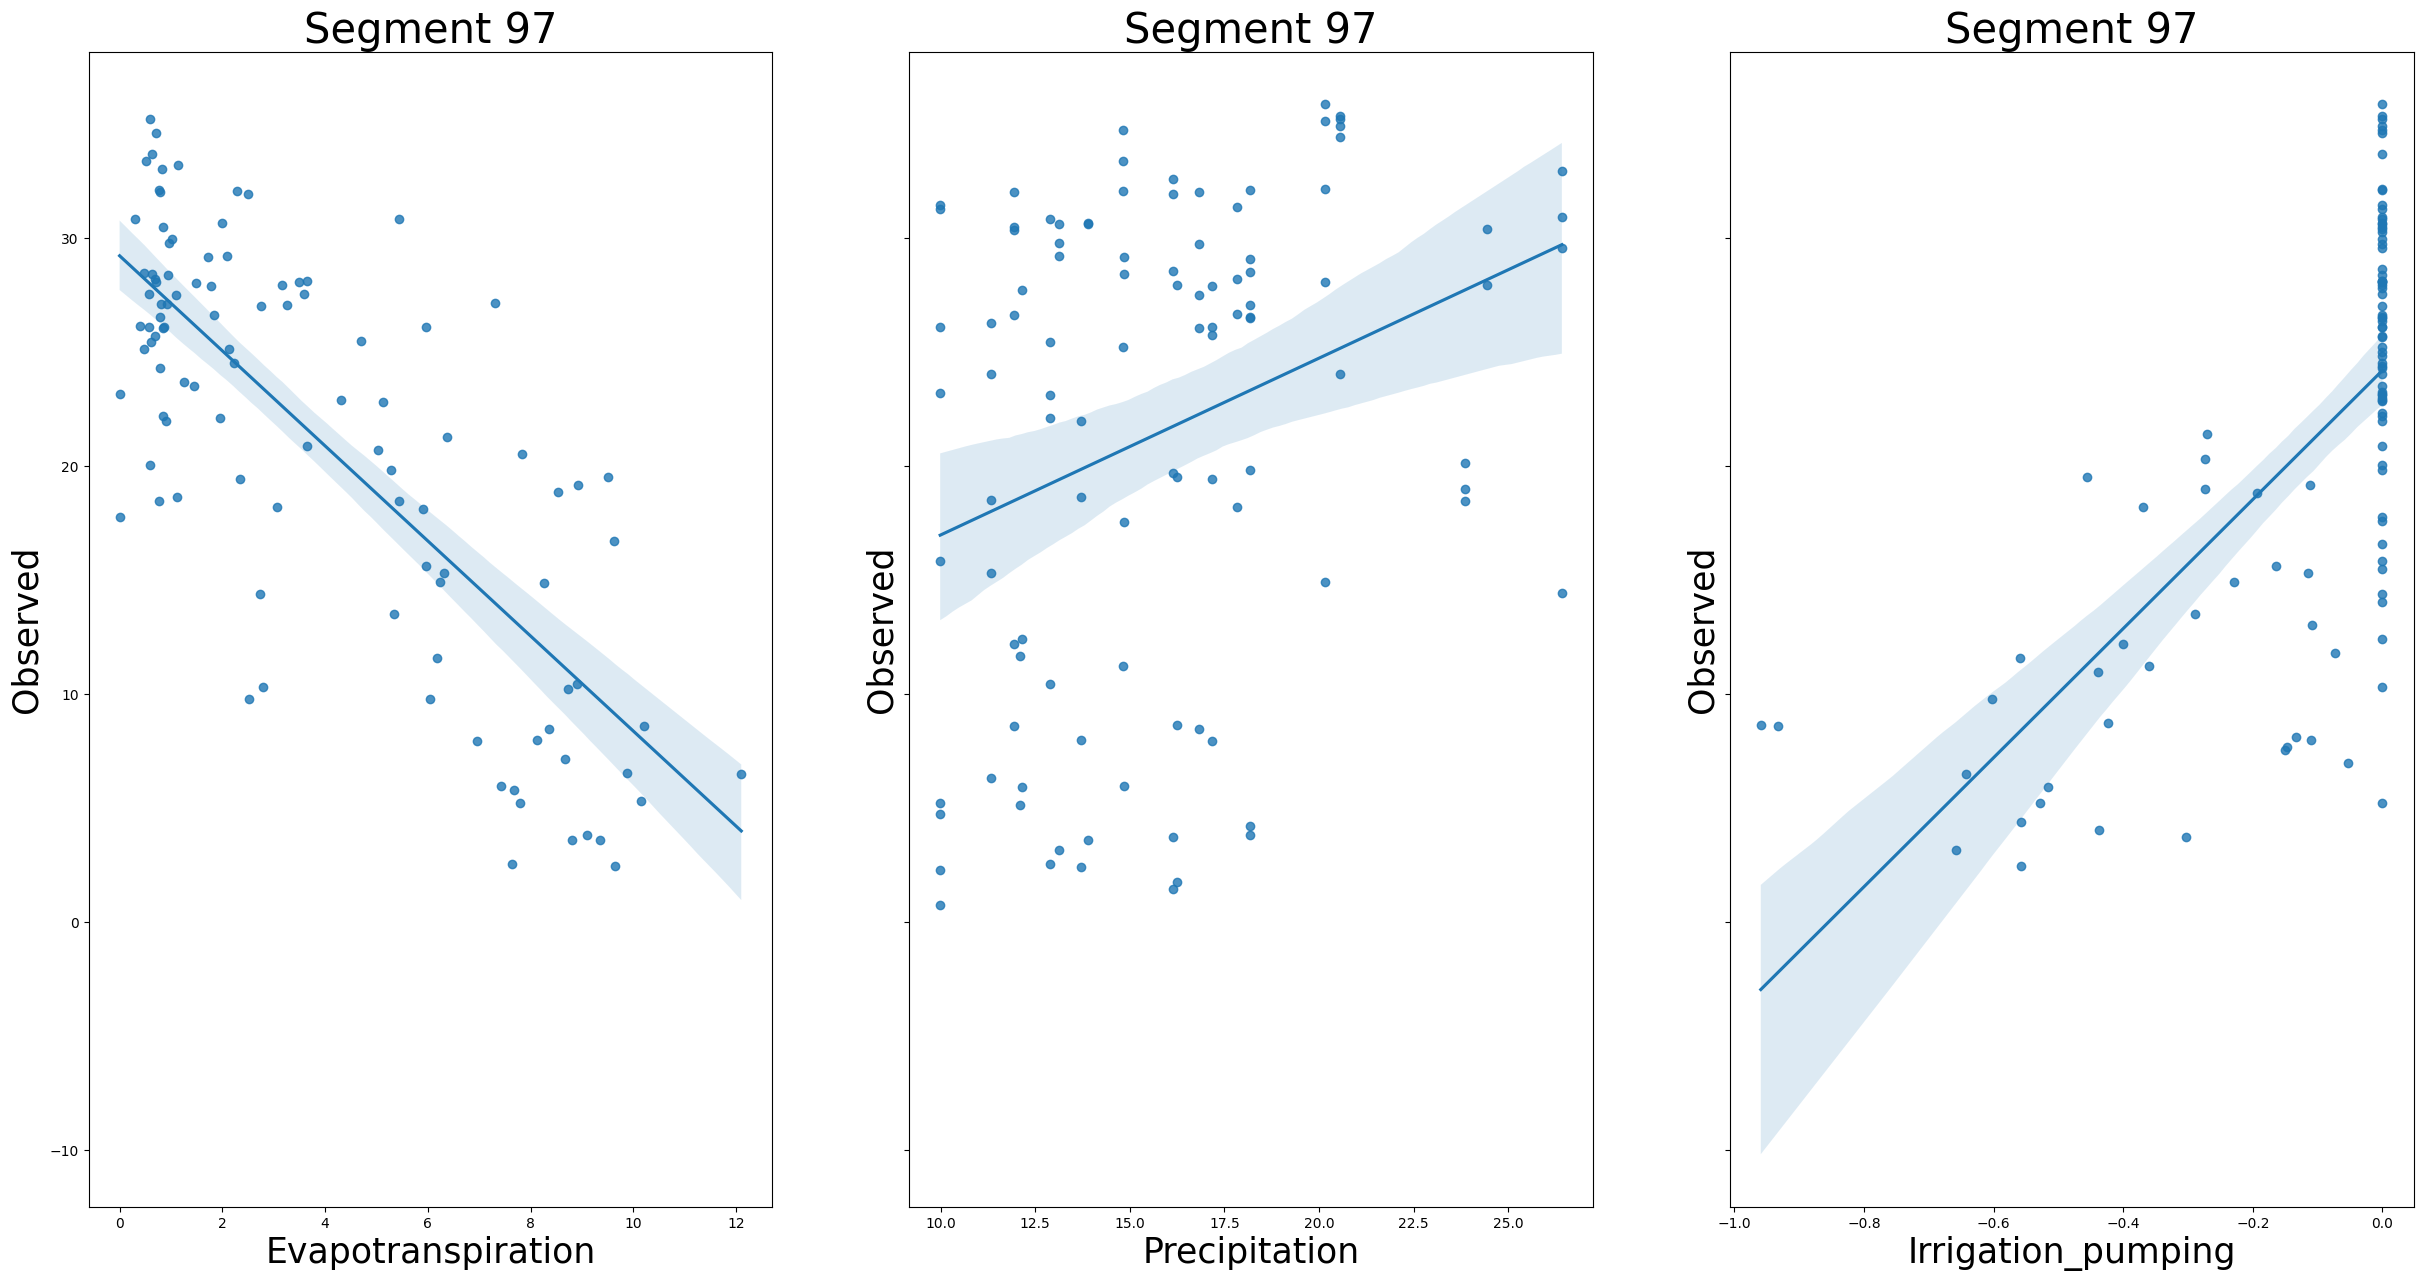

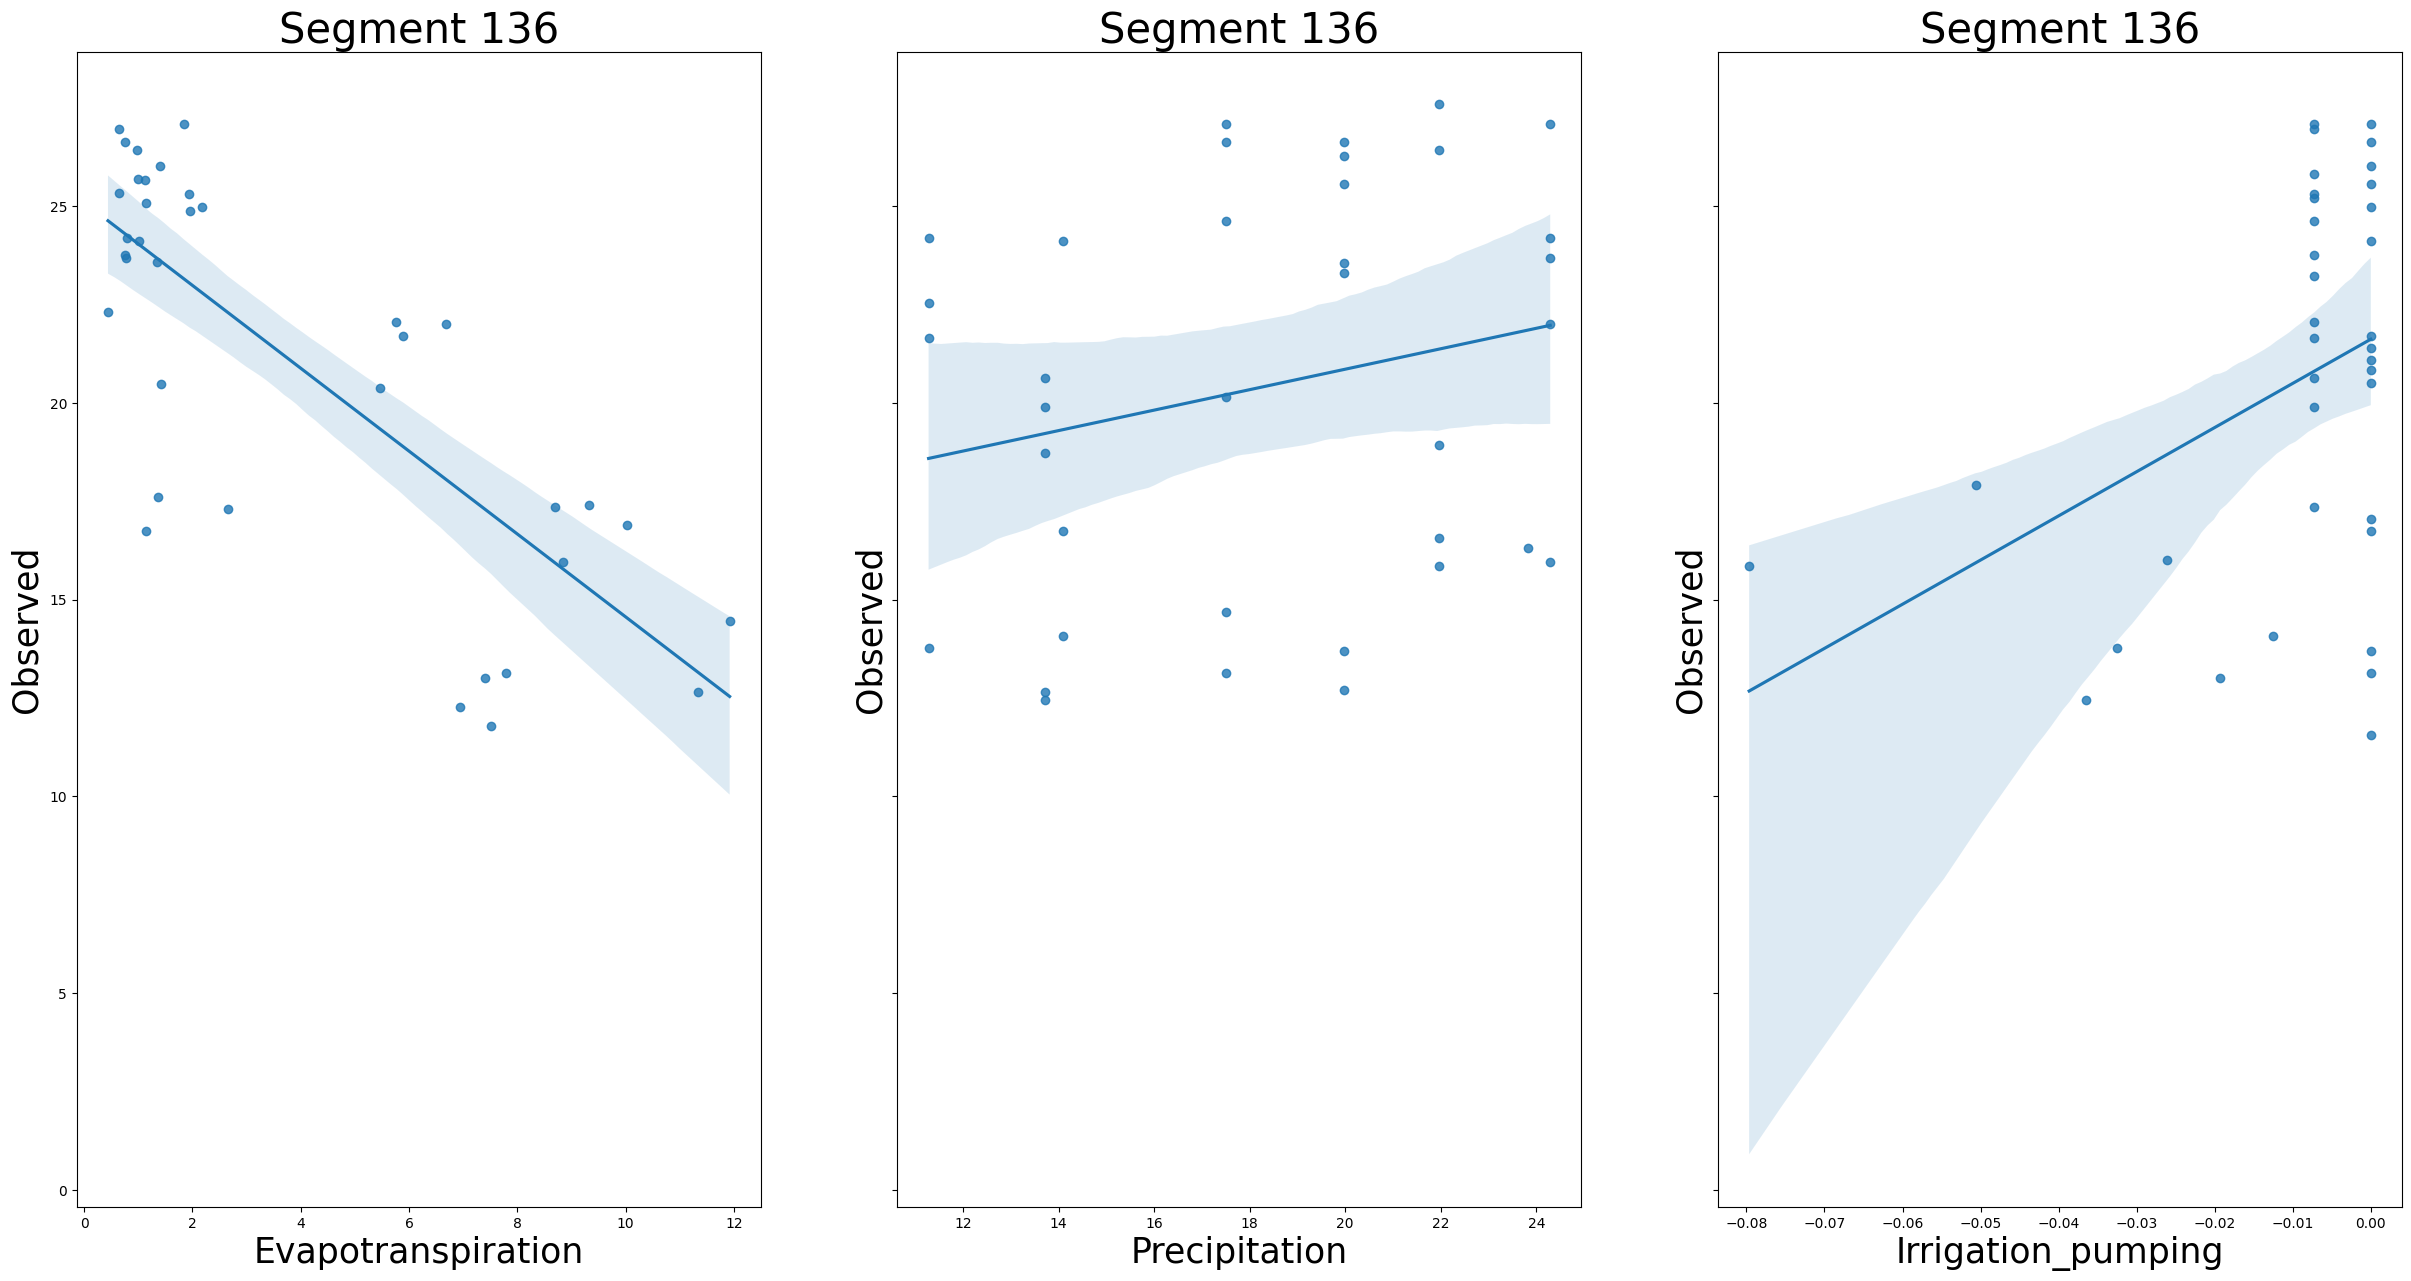

In [11]:
import warnings
# warnings.filterwarnings("ignore", category=stats.PearsonRConstantInputWarning)

optimalSegIdValues = []
for i in segList:
    segid = int(i[4:])
    seg = data[data.Segment_id == segid]
    (r1,p1) = stats.pearsonr(seg.Observed, seg.Evapotranspiration)
    (r2,p2) = stats.pearsonr(seg.Observed, seg.Precipitation)
    (r3,p3) = stats.pearsonr(seg.Observed, seg.Irrigation_pumping)

    if (r1 <= -0.7 or r1 >= 0.7) or (r2 <= -0.7 or r2 >= 0.7) or (r3 <= -0.7 or r3 >= 0.7):
        optimalSegIdValues.append(segid)

for idx in optimalSegIdValues:
    if idx == 123:
        continue
    seg = data[data.Segment_id == idx]
    fig, axs = plt.subplots(1, 3, sharey=True,  figsize=(30, 15))
    sns.regplot(x='Evapotranspiration', y='Observed', ax=axs[0], data=seg.sample(frac=0.4))
    axs[0].set_xlabel('Evapotranspiration', fontsize=25)
    axs[0].set_ylabel('Observed', fontsize=25)
    axs[0].set_title('Segment ' + str(idx), fontsize=30)

    sns.regplot(x='Precipitation', y='Observed', ax=axs[1], data=seg.sample(frac=0.4))
    axs[1].set_xlabel('Precipitation', fontsize=25)
    axs[1].set_ylabel('Observed', fontsize=25)
    axs[1].set_title('Segment ' + str(idx), fontsize=30)

    sns.regplot(x='Irrigation_pumping', y='Observed', ax=axs[2], data=seg.sample(frac=0.4))
    axs[2].set_xlabel('Irrigation_pumping', fontsize=25)
    axs[2].set_ylabel('Observed', fontsize=25)
    axs[2].set_title('Segment ' + str(idx), fontsize=30)


In [12]:
optimal_segList = []
for idx in segList:
    lm = smf.ols(formula=f'Observed ~ {idx}', data=data).fit()
    if list(lm.pvalues)[1] < 0.005:
        optimal_segList.append(idx)
print(optimal_segList)

['Seg_51', 'Seg_53', 'Seg_55', 'Seg_56', 'Seg_59', 'Seg_63', 'Seg_64', 'Seg_65', 'Seg_96', 'Seg_98', 'Seg_118', 'Seg_130', 'Seg_135', 'Seg_138', 'Seg_144', 'Seg_145', 'Seg_146', 'Seg_147', 'Seg_149', 'Seg_152', 'Seg_157', 'Seg_170', 'Seg_171', 'Seg_178', 'Seg_186', 'Seg_188', 'Seg_189', 'Seg_194', 'Seg_196', 'Seg_205', 'Seg_239', 'Seg_256']


In [13]:
ans = ""
for idx in optimal_segList:
    ans = ans + idx
    ans += " + "
ans = ans[:-2]

features = ans
lm = smf.ols(formula=f'Observed ~ {features}', data=data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Observed   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     1953.
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        03:05:11   Log-Likelihood:                -72384.
No. Observations:               15591   AIC:                         1.448e+05
Df Residuals:                   15558   BIC:                         1.451e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.1714      0.537     33.854      0.000      17.119      19.224
Seg_51       -18.0509      1.251    -14.426      0.000     -20.504     -15.598
Seg_53        43.6456      1.710     25.528      0.000      40.294      46.997
Seg_55       -16.7215      1.265    -13.219      0.000     -19.201     -14.242
Seg_56       -14.7993      1.121    -13.202      0.000     -16.997     -12.602
Seg_59        -6.2538      1.080     -5.790      0.000      -8.371      -4.137
Seg_63       -13.7391      2.547     -5.394      0.000     -18.732      -8.746
Seg_64       -12.6641      1.377     -9.194      0.000     -15.364      -9.964
Seg_65       -12.1371      1.087    -11.167      0.000     -14.268     -10.007
Seg_96       -11.2085      1.073    -10.443      0.000     -13.312      -9.105
Seg_98       -17.3665      1.515    -11.462      0.000     -20.336     -14.397
Seg_118      -17.7702      2.780     -6.392      0.000     -23.219     -12.321
Seg_130       36.3815      1.073     33.895      0.000      34.278      38.485
Seg_135      -12.7259      1.583     -8.037      0.000     -15.830      -9.622
Seg_138      -10.3198      1.606     -6.425      0.000     -13.468      -7.172
Seg_144      -12.5543      2.376     -5.283      0.000     -17.212      -7.896
Seg_145      -16.9467      1.369    -12.382      0.000     -19.629     -14.264
Seg_146      -15.9593      1.291    -12.365      0.000     -18.489     -13.429
Seg_147       32.9213      1.126     29.229      0.000      30.714      35.129
Seg_149      -12.0785      1.258     -9.605      0.000     -14.543      -9.614
Seg_152      -14.1359      1.294    -10.922      0.000     -16.673     -11.599
Seg_157       72.0086      2.246     32.065      0.000      67.607      76.410
Seg_170       29.2149      1.162     25.151      0.000      26.938      31.492
Seg_171      -13.5297      1.096    -12.347      0.000     -15.678     -11.382
Seg_178      -10.5137      1.088     -9.663      0.000     -12.646      -8.381
Seg_186       30.6020      2.479     12.346      0.000      25.743      35.460
Seg_188       59.6769      1.177     50.689      0.000      57.369      61.985
Seg_189      -15.4753      1.081    -14.314      0.000     -17.595     -13.356
Seg_194       88.0762      3.012     29.243      0.000      82.172      93.980
Seg_196      -12.6916      1.119    -11.342      0.000     -14.885     -10.498
Seg_205       53.7082      2.396     22.417      0.000      49.012      58.404
Seg_239      355.8608      2.367    150.345      0.000     351.221     360.500
Seg_256      375.5461      2.367    158.661      0.000     370.907     380.186
==============================================================================
Omnibus:                     6649.477   Durbin-Watson:                   0.233
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4511149.294
Sk

In [14]:
features = 'Seg_51 + Seg_53 + Seg_55 + Seg_56 + Seg_59 + Seg_60 + Seg_62 + Seg_63 + Seg_64 + Seg_65 + Seg_96 + Seg_97 + Seg_98 + Seg_118 + Seg_123 + Seg_130 + Seg_135 + Seg_136 + Seg_138 + Seg_144 + Seg_145 + Seg_146 + Seg_147 + Seg_148 + Seg_149 + Seg_152 + Seg_154 + Seg_157 + Seg_159 + Seg_170 + Seg_171 + Seg_176 + Seg_178 + Seg_186 + Seg_188 + Seg_189 + Seg_194 + Seg_196 + Seg_205 + Seg_239 + Seg_256'
features += ' + Month_Aug + Month_Dec + Month_Feb + Month_Jan + Month_Jul + Month_Jun + Month_Mar + Month_May + Month_Nov + Month_Oct + Month_Sep'
lm = smf.ols(formula=f'Observed ~ {features}', data=data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Observed   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     1255.
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        03:05:12   Log-Likelihood:                -72106.
No. Observations:               15591   AIC:                         1.443e+05
Df Residuals:                   15538   BIC:                         1.447e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.9773      1.520     11.824      0.000      14.997      20.958
Seg_51       -13.5630      1.767     -7.678      0.000     -17.026     -10.100
Seg_53        48.0988      2.105     22.846      0.000      43.972      52.225
Seg_55       -12.2619      1.776     -6.905      0.000     -15.743      -8.781
Seg_56       -10.3279      1.680     -6.148      0.000     -13.621      -7.035
Seg_59        -1.8006      1.654     -1.089      0.276      -5.042       1.441
Seg_60         3.4815      1.777      1.959      0.050      -0.002       6.965
Seg_62        -2.6446      3.338     -0.792      0.428      -9.188       3.899
Seg_63        -9.2285      2.807     -3.288      0.001     -14.730      -3.727
Seg_64        -8.1801      1.855     -4.410      0.000     -11.816      -4.544
Seg_65        -7.7523      1.658     -4.675      0.000     -11.002      -4.502
Seg_96        -6.7552      1.650     -4.095      0.000      -9.988      -3.522
Seg_97         7.0042      2.065      3.392      0.001       2.957      11.052
Seg_98       -12.8814      1.956     -6.585      0.000     -16.715      -9.047
Seg_118      -13.4850      3.013     -4.476      0.000     -19.390      -7.580
Seg_123       -0.1956      8.848     -0.022      0.982     -17.539      17.148
Seg_130       40.8347      1.650     24.756      0.000      37.601      44.068
Seg_135       -8.2303      2.008     -4.100      0.000     -12.165      -4.295
Seg_136        7.0427      2.958      2.381      0.017       1.244      12.842
Seg_138       -5.8666      2.025     -2.897      0.004      -9.836      -1.898
Seg_144       -8.7765      2.659     -3.301      0.001     -13.988      -3.565
Seg_145      -12.4505      1.849     -6.735      0.000     -16.074      -8.827
Seg_146      -11.4687      1.794     -6.394      0.000     -14.985      -7.953
Seg_147       37.3649      1.683     22.197      0.000      34.065      40.664
Seg_148        5.9140      1.801      3.283      0.001       2.384       9.444
Seg_149       -7.6380      1.771     -4.313      0.000     -11.109      -4.167
Seg_152       -9.6826      1.796     -5.391      0.000     -13.203      -6.162
Seg_154       -8.4761      3.578     -2.369      0.018     -15.489      -1.463
Seg_157       76.5000      2.546     30.050      0.000      71.510      81.490
Seg_159        9.1757      1.916      4.788      0.000       5.419      12.932
Seg_170       33.6616      1.706     19.728      0.000      30.317      37.006
Seg_171       -9.3003      1.664     -5.590      0.000     -12.561      -6.039
Seg_176        3.8612      2.618      1.475      0.140      -1.271       8.993
Seg_178       -6.0790      1.659     -3.665      0.000      -9.331      -2.828
Seg_186       35.0552      2.747     12.763      0.000      29.671      40.439
Seg_188       64.1301      1.717     37.357      0.000      60.765      67.495
Se

In [15]:
newData = data[data.Year > 1970]
features = 'Seg_51 + Seg_53 + Seg_55 + Seg_56 + Seg_59 + Seg_60 + Seg_62 + Seg_63 + Seg_64 + Seg_65 + Seg_96 + Seg_97 + Seg_98 + Seg_118 + Seg_123 + Seg_130 + Seg_135 + Seg_136 + Seg_138 + Seg_144 + Seg_145 + Seg_146 + Seg_147 + Seg_148 + Seg_149 + Seg_152 + Seg_154 + Seg_157 + Seg_159 + Seg_170 + Seg_171 + Seg_176 + Seg_178 + Seg_186 + Seg_188 + Seg_189 + Seg_194 + Seg_196 + Seg_205 + Seg_239 + Seg_256'
features += ' + Month_Aug + Month_Dec + Month_Feb + Month_Jan + Month_Jul + Month_Jun + Month_Mar + Month_May + Month_Nov + Month_Oct + Month_Sep + Evapotranspiration + Precipitation + Irrigation_pumping'
lm = smf.ols(formula=f'Observed ~ {features}', data=newData).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Observed   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     1585.
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        03:05:12   Log-Likelihood:                -22331.
No. Observations:                7019   AIC:                         4.474e+04
Df Residuals:                    6978   BIC:                         4.503e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             13.7914      0.644     21.426      0.000      12.530      15.053
Seg_51               -11.6366      0.659    -17.662      0.000     -12.928     -10.345
Seg_53              1.173e-14   2.03e-15      5.764      0.000    7.74e-15    1.57e-14
Seg_55               -10.3994      0.569    -18.284      0.000     -11.514      -9.284
Seg_56                -6.6716      0.659    -10.126      0.000      -7.963      -5.380
Seg_59                -0.9280      0.506     -1.833      0.067      -1.921       0.064
Seg_60                 4.0182      0.483      8.318      0.000       3.071       4.965
Seg_62              1.432e-15   2.13e-15      0.671      0.502   -2.75e-15    5.62e-15
Seg_63              3.756e-15    8.9e-16      4.218      0.000    2.01e-15     5.5e-15
Seg_64                -7.5755      0.509    -14.873      0.000      -8.574      -6.577
Seg_65                -7.1651      0.500    -14.333      0.000      -8.145      -6.185
Seg_96                -6.6345      0.499    -13.289      0.000      -7.613      -5.656
Seg_97                 5.9874      2.105      2.844      0.004       1.861      10.114
Seg_98               -11.5253      0.921    -12.510      0.000     -13.331      -9.719
Seg_118            -1.045e-14   9.89e-16    -10.566      0.000   -1.24e-14   -8.51e-15
Seg_123            -4.554e-15   6.69e-16     -6.805      0.000   -5.87e-15   -3.24e-15
Seg_130               35.8334      0.497     72.050      0.000      34.858      36.808
Seg_135               -7.8728      0.555    -14.185      0.000      -8.961      -6.785
Seg_136            -4.211e-16   2.69e-16     -1.568      0.117   -9.48e-16    1.05e-16
Seg_138               -5.1849      0.506    -10.252      0.000      -6.176      -4.193
Seg_144               -9.5705      0.976     -9.808      0.000     -11.483      -7.658
Seg_145              -10.7181      0.875    -12.246      0.000     -12.434      -9.002
Seg_146               -9.5214      0.659    -14.452      0.000     -10.813      -8.230
Seg_147               21.5877      0.511     42.234      0.000      20.586      22.590
Seg_148                6.1641      0.486     12.679      0.000       5.211       7.117
Seg_149               -6.2058      0.519    -11.951      0.000      -7.224      -5.188
Seg_152               -3.6790      0.757     -4.861      0.000      -5.163      -2.195
Seg_154            -4.636e-15   9.86e-17    -47.004      0.000   -4.83e-15   -4.44e-15
Seg_157            -7.624e-15   7.98e-17    -95.486      0.000   -7.78e-15   -7.47e-15
Seg_159            -2.556e-15   9.42e-17    -27.120      0.000   -2.74e-15   -2.37e-15
Seg_170               32.2654      0.482     66.947      0.000      31.321      33.210
Seg_171               -7.7839      0.595    -13.092      0.000      -8.949      -6.618
Seg_176             -1.86e-15    6.1e-

In [16]:
def getMeanSquaredValue(feature_cols):
    newData = data[data.Year > 1970]
    X = newData[feature_cols]
    y = newData.Observed

    max_value = 9223372036854775807

    for idx in range(1, 5):
        test_size = idx/10
        for random_state in range(1, 70):
            # assume X is your input features and y is your target variable
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

            # train a linear regression model
            model = LinearRegression()
            model.fit(X_train, y_train)

            # make predictions on the testing set
            y_pred = model.predict(X_test)

            # calculate MSE
            mse = mean_squared_error(y_test, y_pred)
            max_value = min(max_value, mse)
    return max_value

In [17]:
print("Mean Squared Error: with considering 'Evapotranspiration'", getMeanSquaredValue(['Evapotranspiration']))

print("Mean Squared Error: with considering 'Precipitation'", getMeanSquaredValue(['Precipitation']))

print("Mean Squared Error: with considering 'Irrigation_pumping', 'Evapotranspiration','Precipitation'", getMeanSquaredValue(['Irrigation_pumping', 'Evapotranspiration','Precipitation']))

print("Mean Squared Error: with considering 'Evapotranspiration','Irrigation_pumping'", getMeanSquaredValue(['Evapotranspiration','Irrigation_pumping']))

print("Mean Squared Error: with considering 'Evapotranspiration', 'Precipitation'", getMeanSquaredValue(['Evapotranspiration', 'Precipitation']))

feature_cols = ['Seg_51', 'Seg_53', 'Seg_55', 'Seg_56', 'Seg_59', 'Seg_60', 'Seg_62', 'Seg_63', 'Seg_64', 'Seg_65', 'Seg_96', 'Seg_97', 'Seg_98',  'Seg_118', 'Seg_123' , 'Seg_130', 'Seg_135', 'Seg_136', 'Seg_138', 'Seg_144', 'Seg_145', 'Seg_146', 'Seg_147', 'Seg_148', 'Seg_149' , 'Seg_152', 'Seg_154', 'Seg_157' , 'Seg_159', 'Seg_170', 'Seg_171', 'Seg_176', 'Seg_178' ,'Seg_186', 'Seg_188', 'Seg_189'  ,'Seg_194', 'Seg_196' ,'Seg_205' ,'Seg_239', 'Seg_256']
print("Mean Squared Error: with considering all segments", getMeanSquaredValue(feature_cols))

months_col = ['Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jan', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep']
feature_cols.extend(months_col)
print("Mean Squared Error: with considering all segments and months", getMeanSquaredValue(feature_cols))

Mean Squared Error: with considering 'Evapotranspiration' 275.69742112817175
Mean Squared Error: with considering 'Precipitation' 249.10989193535977
Mean Squared Error: with considering 'Irrigation_pumping', 'Evapotranspiration','Precipitation' 247.64060819636254
Mean Squared Error: with considering 'Evapotranspiration','Irrigation_pumping' 271.96150600038607
Mean Squared Error: with considering 'Evapotranspiration', 'Precipitation' 249.7627110139118
Mean Squared Error: with considering all segments 33.70545307643712
Mean Squared Error: with considering all segments and months 29.019722292644975


In [18]:
dataCols = ['Evapotranspiration', 'Precipitation', 'Irrigation_pumping']
feature_cols.extend(dataCols)
print("Mean Squared Error: with considering all segments, 'Irrigation_pumping', 'Evapotranspiration','Precipitation' columns and months\n", getMeanSquaredValue(feature_cols))

Mean Squared Error: with considering all segments, 'Irrigation_pumping', 'Evapotranspiration','Precipitation' columns and months
 27.926348144869944


<Axes: >

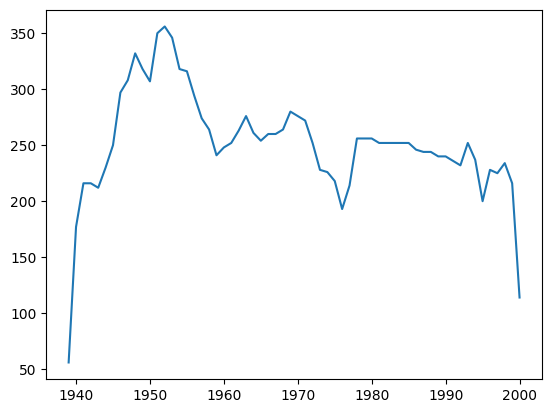

In [19]:
years = []
count = []
for i in range(1939, 2001):
    years.append(i)
    count.append(len(data[data.Year == i]))
sns.lineplot(x=years,y=count)

Text(0, 0.5, 'Mean Baseflow')

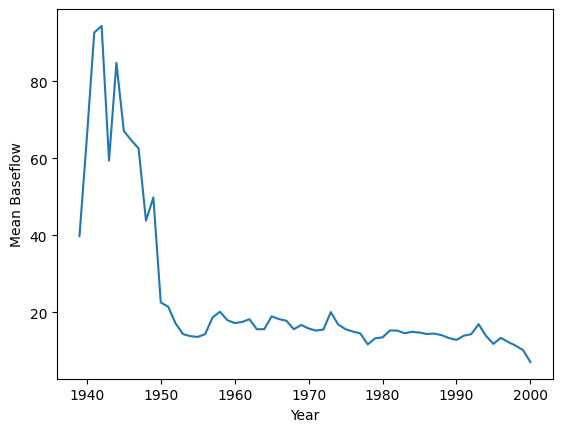

In [20]:
years = []
count = []
for i in range(1939, 2001):
    years.append(i)
    count.append(data[data.Year == i].Observed.mean())
sns.lineplot(x=years,y=count)
plt.xlabel('Year')
plt.ylabel('Mean Baseflow')

Text(0, 0.5, 'Max Baseflow')

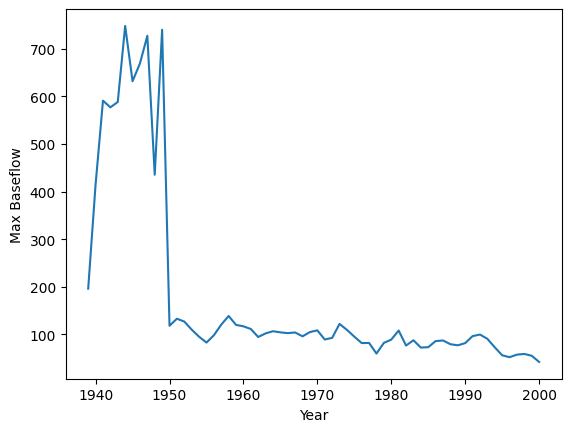

In [21]:
years = []
count = []
for i in range(1939, 2001):
    years.append(i)
    count.append(data[data.Year == i].Observed.max())
sns.lineplot(x=years,y=count)
plt.xlabel('Year')
plt.ylabel('Max Baseflow')

        Date  Segment_id        x         y  Evapotranspiration  \
14005  29612         189  1392430  14571840                 0.0   
14006  29643         189  1392430  14571840                 0.0   
14007  29673         189  1392430  14571840                 0.0   
14008  29704         189  1392430  14571840                 0.0   
14009  29734         189  1392430  14571840                 0.0   
...      ...         ...      ...       ...                 ...   
14108  32748         189  1392430  14571840                 0.0   
14109  32779         189  1392430  14571840                 0.0   
14110  32809         189  1392430  14571840                 0.0   
14111  32840         189  1392430  14571840                 0.0   
14112  32871         189  1392430  14571840                 0.0   

       Precipitation  Irrigation_pumping  Observed Month  Year  ...  Seg_178  \
14005            0.0                 0.0       0.0   Jan  1981  ...        0   
14006            0.0               

<Axes: xlabel='Month', ylabel='Observed'>

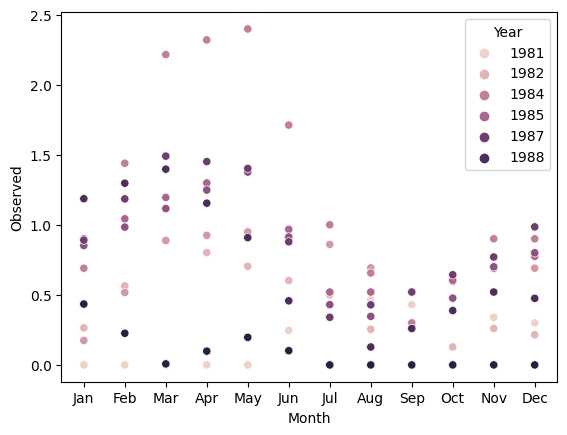

In [22]:
test = data[data['Segment_id'] == 189]
test = test[test.Year > 1980]
test = test[test.Year < 1990]

print(test)
sns.scatterplot(data=test, x='Month', y='Observed', hue='Year')